# CIDAUT AI Fake Scene Classification 2024

---
author: Brice Piaple Dada
date: December 21, 2024
---

## Unzip the data

In [7]:
#| echo: true


import zipfile

# Path to the .zip file
zip_file_path = 'Data/cidaut-ai-fake-scene-classification-2024.zip'

# Path toi extract teh contents
extract_path = 'Data/Unzip_data'

# Open the .zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip:
    zip.extractall(extract_path)
    
    print("Extractiob Complete.")


Extractiob Complete.


## Import our libraries

In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

## Load our data

###  Load our csv and images files

In [9]:
def load_image(image_path: str) -> tf.Tensor:
    """Loads an image from the specified file path, decodes it as a JPEG, resizes it to 224x224 pixels,
    and normalizes the pixel values to the range [0, 1].
    
    Args:
        image_path (str): The file path to the image.

    Returns:
        tf.Tensor: A tensor representing the processed image.
    """
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image


In [84]:
images_dir = 'Data/Unzip_data/Train'
df = pd.read_csv('Data/Unzip_data/train.csv')

In [85]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Encode the labels
df['label'] = encoder.fit_transform(df['label'])

# Create a list of file paths to the images
file_paths = [os.path.join(images_dir, file_name) for file_name in df['image']]
file_paths[:5]

['Data/Unzip_data/Train/1.jpg',
 'Data/Unzip_data/Train/2.jpg',
 'Data/Unzip_data/Train/3.jpg',
 'Data/Unzip_data/Train/6.jpg',
 'Data/Unzip_data/Train/8.jpg']

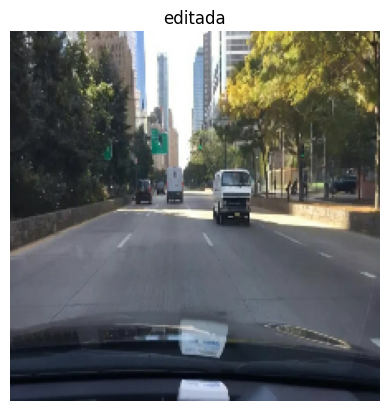

In [109]:

## Load an image from the DataFrame
import random
import matplotlib.pyplot as plt

image_number = random.randint(0, len(file_paths))

image = load_image(file_paths[image_number])

## Display the image
plt.imshow(image)

# show the label of the image as the title and the label converted back to its original form
plt.title(encoder.inverse_transform([df['label'][image_number]])[0])


plt.axis('off')
plt.show()

In [132]:
## Split the data into training and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(file_paths, df['label'], test_size=0.2, random_state=42)

In [133]:
## Create a function to preprocess the images and labels

def preprocess_image(image_path, label):
    """Loads an image from the specified file path and preprocesses it.
    
    Args:
        image_path (str): The file path to the image.
        label (int): The label associated with the image.
    
    Returns:
        Tuple[tf.Tensor, int]: A tensor representing the processed image and the label.
    """
    image = load_image(image_path)
    return image, label

In [165]:
# Get a random image and its label
random_image_index = random.randint(0, len(X_train) - 1)
random_image_path = X_train[random_image_index]
random_image_label = y_train.iloc[random_image_index]

print(f"Image path: {random_image_path}")
print(f"Image label: {random_image_label}")

Image path: Data/Unzip_data/Train/383.jpg
Image label: 0


In [167]:
# Preprocess the image
random_processed_image, random_processed_label = preprocess_image(random_image_path, random_image_label)

print(f"Image shape: {random_processed_image.shape}")
print(f"Label: {random_processed_label}")


Image shape: (224, 224, 3)
Label: 0


In [168]:
## Create a function to preprocess the data

def create_data_batches(X, y=None, batch_size=32, valid_data=False, test_data=False):
    """Creates batches of data out of image (X) and label (y) pairs.

    Args:
        X (_type_): _description_
        y (_type_, optional): _description_. Defaults to None.
        batch_size (int, optional): _description_. Defaults to 32.
        valid_data (bool, optional): _description_. Defaults to False.
        test_data (bool, optional): _description_. Defaults to False.
    """
    
    # If the data is a test dataset, we probably don't have have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only file paths (no labels)
        data_batch = data.map(load_image).batch(batch_size)
        return data_batch
    
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # file paths and labels
        data = data.map(preprocess_image).batch(batch_size)
        return data
    
    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # file paths and labels
        data = data.shuffle(buffer_size=len(X))
        data = data.map(preprocess_image).batch(batch_size)
        return data

In [170]:
# Create training and validation data batches
batch_size = 32

train_data = create_data_batches(X_train, y_train, batch_size=batch_size)
val_data = create_data_batches(X_val, y_val, batch_size=batch_size, valid_data=True)

# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec


Creating training data batches...
Creating validation data batches...


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

In [ ]:
## Create a function to create a model

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def create_model(input_shape=(224, 224, 3), num_classes=5):
    """Creates a CNN model using the Sequential API.
    
    Args:
        input_shape (tuple, optional): The shape of the input data. Defaults to (224, 224, 3).
        num_classes (int, optional): The number of output classes. Defaults to 5.
    
    Returns:
        tf.keras.Model: A CNN model.
    """
    
    # Create a base model
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    base_model.trainable = False
    
    # Create a Sequential model
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    return model

In [175]:
# Create a model and check its details
model = create_model(num_classes=len(encoder.classes_))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Fit the model

In [176]:

# Define the number of epochs
epochs = 5

# Fit the model
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data)


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step - accuracy: 0.5536 - loss: 0.6828 - val_accuracy: 0.5347 - val_loss: 0.6908
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.5692 - loss: 0.6874 - val_accuracy: 0.5347 - val_loss: 0.6923
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - accuracy: 0.5532 - loss: 0.6915 - val_accuracy: 0.5347 - val_loss: 0.7003
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - accuracy: 0.5629 - loss: 0.6855 - val_accuracy: 0.5347 - val_loss: 0.6968
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - accuracy: 0.5648 - loss: 0.7065 - val_accuracy: 0.5347 - val_loss: 0.6910



## Plot the training curves


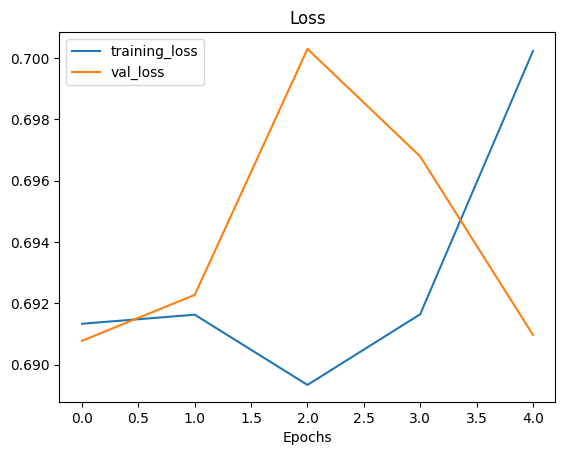

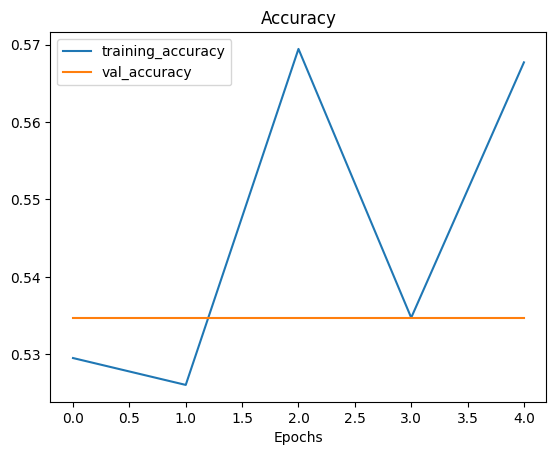

In [177]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """Plots the loss and accuracy curves for the training and validation sets.
    
    Args:
        history (History): The history object returned from model training.
    """
    
    # Get the loss and accuracy metrics
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    # Get the number of epochs
    epochs = range(len(history.history['loss']))
    
    # Plot the loss
    plt.figure()
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot the accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()
    
plot_loss_curves(history)

## Create a function to load and preprocess an image

def load_and_prep_image(file_path):
    """Loads an image from the specified file path, preprocesses it, and reshapes it to (1, 224, 224, 3).
    
    Args:
        file_path (str): The file path to the image.
    
    Returns:
        tf.Tensor: A tensor representing the processed image.
    """
    
    # Load the image
    image = load_image(file_path)
    
    # Add an extra dimension
    image = tf.expand_dims(image, axis=0)
    
    return image


In [178]:

# Load and preprocess an image

image_path = 'Data/Unzip_data/Test/4.jpg'
image = load_and_prep_image(image_path)

# Make predictions
pred = model.predict(image)
pred



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.45633405, 0.54366595]], dtype=float32)

In [179]:
# Get the predicted class
predicted_class = encoder.inverse_transform([np.argmax(pred)])[0]
predicted_class

'real'

In [184]:
## Create a function to make predictions on a batch of images

def make_predictions(model, file_paths):
    """Makes predictions on a batch of images.
    
    Args:
        model (tf.keras.Model): A trained model.
        file_paths (list): A list of file paths to the images.
    
    Returns:
        list: A list of predicted class labels.
    """
    
    # Load and preprocess the images
    images = [load_and_prep_image(file_path) for file_path in file_paths]
    
    # Make predictions
    preds = [model.predict(image) for image in images]
    
    # Get the predicted class
    predicted_classes = [encoder.inverse_transform([np.argmax(pred)])[0] for pred in preds]
    
    return predicted_classes

# Get a batch of images of all the test images
test_images_dir = 'Data/Unzip_data/Test'
test_image_paths = [os.path.join(test_images_dir, file_name) for file_name in os.listdir(test_images_dir)]
batch_image_paths = test_image_paths[:32]

# Make predictions
batch_preds = make_predictions(model, batch_image_paths)
batch_preds



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

['real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real']

In [185]:
# Create a DataFrame with the image names and their predicted classes
test_image_names = [os.path.splitext(os.path.basename(file_path))[0] for file_path in batch_image_paths]
test_predictions = make_predictions(model, batch_image_paths)

test_results = pd.DataFrame({
    'Image': test_image_names,
    'Label': test_predictions
})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [186]:
test_results

,Image,Label
0,770,real
1,785,real
2,786,real
3,792,real
4,799,real
5,801,real
6,802,real
7,808,real
8,811,real
9,82,real


In [187]:
## Save the predictions to a CSV file

test_results.to_csv('Data/Unzip_data/test_predictions.csv', index=False)